In [1]:
import numpy as np
import scipy

import cupy as cp
import cupyx.scipy

import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload
import time

import warnings
warnings.filterwarnings("ignore")

import poppy
import hcipy as hci

import wfsc_tests as wfsc
wfsc.math_module.update_np(np)
wfsc.math_module.update_scipy(scipy)

import misc_funs as misc

from matplotlib.colors import ListedColormap
#Blue to Red Color scale for S1 and S2
colmap = np.zeros((255,3));
# Red
colmap[126:183,0]= np.linspace(0,1,57);
colmap[183:255,0]= 1;
# Green
colmap[0:96,1] = np.linspace(1,0,96);
colmap[158:255,1]= np.linspace(0,1,97);
# Blue
colmap[0:71,2] = 1;
colmap[71:128,2]= np.linspace(1,0,57);
colmap2 = colmap[128:,:]
colmap = ListedColormap(colmap)

In [2]:
class CORO():

    def __init__(self, 
                 wavelength=None, 
                ):
        
        self.wavelength_c = 575e-9*u.m
        self.wavelength = self.wavelength_c if wavelength is None else wavelength
        self.f = 500*u.mm
        
        self.dm_diam = 10.2*u.mm
        self.dm1_dm2 = 200e-3*u.m
        
        self.FN = (self.dm_diam**2/self.dm1_dm2/self.wavelength).decompose()
        
        # define the grids
        self.npix = 256
        self.oversample = 2
        self.spatial_resolution = self.f.to_value(u.m) * self.wavelength.to_value(u.m) / self.dm_diam.to_value(u.m)
        self.npsf = 64
        self.psf_pixelscale_lamD = self.spatial_resolution/self.f.to_value(u.m)*(self.dm_diam/self.wavelength_c).decompose().value/2
        
        self.pupil_grid = hci.make_pupil_grid(self.npix*self.oversample, self.dm_diam.to_value(u.m) * self.oversample)
        self.focal_grid = hci.make_focal_grid(2, 16, spatial_resolution=self.spatial_resolution)
        self.prop = hci.FraunhoferPropagator(self.pupil_grid, self.focal_grid, self.f.to_value(u.m))

        self.aperture = hci.Field(np.exp(-(self.pupil_grid.as_('polar').r / (0.5 * self.dm_diam.to_value(u.m)))**30), self.pupil_grid)
        
        # define the DMs
        self.Nact = 34
        actuator_spacing = 1.00 / self.Nact * self.dm_diam.to_value(u.m)
        
        influence_functions = hci.make_gaussian_influence_functions(self.pupil_grid, self.Nact, actuator_spacing)
        
        self.DM1 = hci.DeformableMirror(influence_functions)
        self.DM2 = hci.DeformableMirror(influence_functions)

        self.prop_between_dms = hci.FresnelPropagator(self.pupil_grid, self.dm1_dm2.to_value(u.m))
        
        self.dm_mask = np.ones((self.Nact,self.Nact), dtype=bool)
        xx = (np.linspace(0, self.Nact-1, self.Nact) - self.Nact/2 + 1/2) * actuator_spacing*2
        x,y = np.meshgrid(xx,xx)
        r = np.sqrt(x**2 + y**2)
        self.dm_mask[r>0.0105] = 0 # had to set the threshold to 10.5 instead of 10.2 to include edge actuators
        
#         self.dm_zernikes = poppy.zernike.arbitrary_basis(self.dm_mask, nterms=15, outside=0)
        self.dm_zernikes = poppy.zernike.arbitrary_basis(cp.array(self.dm_mask), nterms=15, outside=0).get()
        
        # make the aberrations of the system (make sure to remove tip-tilt)
        aberration_ptv = 0.02 * self.wavelength.to_value(u.m)
        tip_tilt = hci.make_zernike_basis(3, self.dm_diam.to_value(u.m), self.pupil_grid, starting_mode=2)
        wfe = hci.SurfaceAberration(self.pupil_grid, aberration_ptv, self.dm_diam.to_value(u.m), remove_modes=tip_tilt, exponent=-3)
        aberration_distance_m = 100e-3
        self.wfe_at_distance = hci.SurfaceAberrationAtDistance(wfe, aberration_distance_m)
        
        # make the coronagraph model
        self.coronagraph = hci.PerfectCoronagraph(self.aperture, order=6)
        
        
    def set_dm1(self, command):
        self.DM1.actuators = command.ravel()
        
    def set_dm2(self, command):
        self.DM2.actuators = command.ravel()
        
    def add_dm1(self, command):
        self.DM1.actuators += command.ravel()
        
    def add_dm2(self, command):
        self.DM2.actuators += command.ravel()
        
    def get_dm1(self):
        return self.DM1.actuators.reshape(self.Nact, self.Nact)
        
    def get_dm2(self):
        return self.DM2.actuators.reshape(self.Nact, self.Nact)
    
    def reset_dms(self):
        self.DM1.actuators = np.zeros((self.Nact, self.Nact)).ravel()
        self.DM2.actuators = np.zeros((self.Nact, self.Nact)).ravel()
    
    def show_dms(self):
        misc.imshow2(self.DM1.actuators.reshape(c.Nact, c.Nact),
                     self.DM2.actuators.reshape(c.Nact, c.Nact))
        
    def calc_psf(self):
        wf = hci.Wavefront(self.aperture, self.wavelength.to_value(u.m))
        wf = self.wfe_at_distance(wf) # apply aberrations to wavefront
        wf = self.prop_between_dms.backward(self.DM2(self.prop_between_dms.forward(self.DM1(wf)))) # apply DMs
        wf = self.prop(self.coronagraph(wf))
        psf_wf = wf.real.shaped + 1j*wf.imag.shaped

        return np.array(psf_wf)

    def snap(self):
        wf = hci.Wavefront(self.aperture, self.wavelength.to_value(u.m))
        wf = self.wfe_at_distance(wf) # apply aberrations to wavefront
        wf = self.prop_between_dms.backward(self.DM2(self.prop_between_dms.forward(self.DM1(wf)))) # apply DMs
        im = self.prop(self.coronagraph(wf))

        return np.array(im.intensity.shaped)
    
c = CORO()


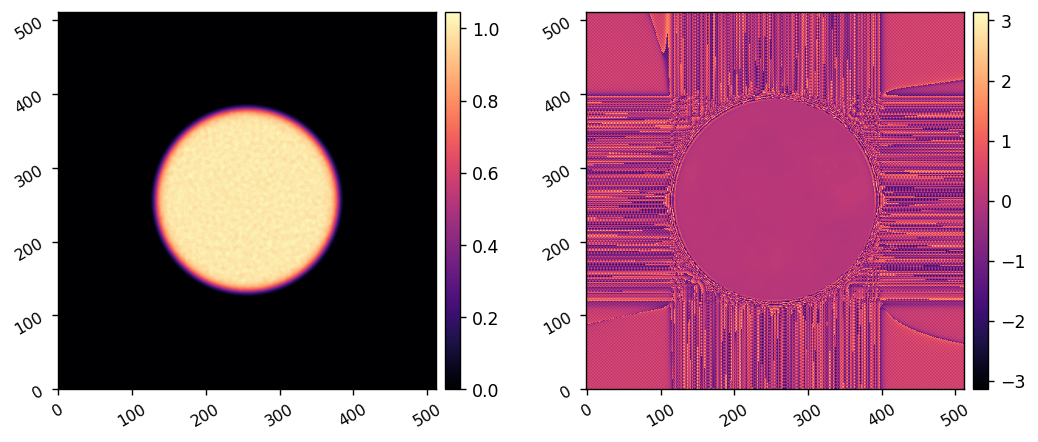

In [3]:
aberrated_pupil = c.wfe_at_distance(hci.Wavefront(c.aperture, c.wavelength.to_value(u.m)))

misc.imshow2(aberrated_pupil.intensity.shaped, aberrated_pupil.phase.shaped)

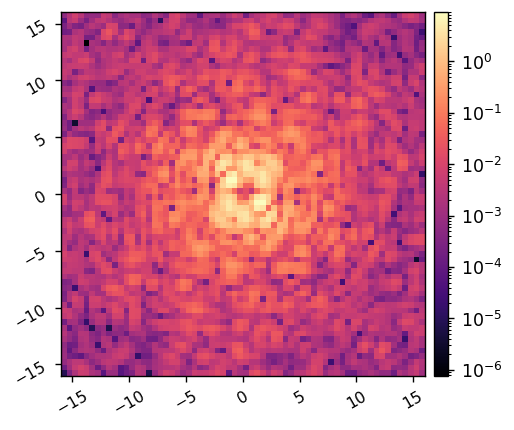

In [4]:
Nact = c.Nact
npsf = c.npsf

c.reset_dms()
ref_im = c.snap()

misc.imshow1(ref_im, lognorm=True, pxscl=c.psf_pixelscale_lamD)

# define the dark hole region

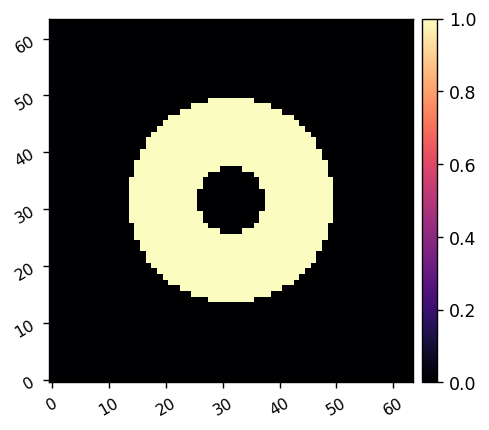

In [5]:
reload(wfsc)
reload(wfsc.utils)
reload(wfsc.imshows)
xfp = (np.linspace(-npsf/2, npsf/2-1, npsf) + 1/2)*c.psf_pixelscale_lamD
fpx,fpy = np.meshgrid(xfp,xfp)
fpr = np.sqrt(fpx**2 + fpy**2)
    
iwa = 3
owa = 9
roi_params = {
        'inner_radius' : iwa,
        'outer_radius' : owa,
#         'edge' : None,
        'rotation':0,
        'full':True,
    }
dark_mask = wfsc.utils.create_annular_focal_plane_mask(fpx, fpy, roi_params, plot=True)

probe_amp = 3e-8
calib_amp = 5e-9

In [10]:
reload(wfsc.efc_2dm)

c.reset_dms()

epsilon = 1e-9 # poke amplitudes (DM surface)
jac = wfsc.efc_2dm.build_jacobian(c, epsilon, dark_mask.ravel(), display=False)

Building Jacobian.
	Calculated response for mode 1/952. Elapsed time=0.820 sec.
	Calculated response for mode 2/952. Elapsed time=1.633 sec.
	Calculated response for mode 3/952. Elapsed time=2.449 sec.
	Calculated response for mode 4/952. Elapsed time=3.264 sec.
	Calculated response for mode 5/952. Elapsed time=4.074 sec.
	Calculated response for mode 6/952. Elapsed time=4.889 sec.
	Calculated response for mode 7/952. Elapsed time=5.702 sec.
	Calculated response for mode 8/952. Elapsed time=6.521 sec.
	Calculated response for mode 9/952. Elapsed time=7.330 sec.
	Calculated response for mode 10/952. Elapsed time=8.146 sec.
	Calculated response for mode 11/952. Elapsed time=8.961 sec.
	Calculated response for mode 12/952. Elapsed time=9.775 sec.
	Calculated response for mode 13/952. Elapsed time=10.588 sec.
	Calculated response for mode 14/952. Elapsed time=11.398 sec.
	Calculated response for mode 15/952. Elapsed time=12.209 sec.
	Calculated response for mode 16/952. Elapsed time=13.025

	Calculated response for mode 131/952. Elapsed time=106.401 sec.
	Calculated response for mode 132/952. Elapsed time=107.212 sec.
	Calculated response for mode 133/952. Elapsed time=108.025 sec.
	Calculated response for mode 134/952. Elapsed time=108.835 sec.
	Calculated response for mode 135/952. Elapsed time=109.644 sec.
	Calculated response for mode 136/952. Elapsed time=110.456 sec.
	Calculated response for mode 137/952. Elapsed time=111.269 sec.
	Calculated response for mode 138/952. Elapsed time=112.076 sec.
	Calculated response for mode 139/952. Elapsed time=112.887 sec.
	Calculated response for mode 140/952. Elapsed time=113.704 sec.
	Calculated response for mode 141/952. Elapsed time=114.513 sec.
	Calculated response for mode 142/952. Elapsed time=115.322 sec.
	Calculated response for mode 143/952. Elapsed time=116.134 sec.
	Calculated response for mode 144/952. Elapsed time=116.945 sec.
	Calculated response for mode 145/952. Elapsed time=117.753 sec.
	Calculated response for 

	Calculated response for mode 258/952. Elapsed time=209.414 sec.
	Calculated response for mode 259/952. Elapsed time=210.227 sec.
	Calculated response for mode 260/952. Elapsed time=211.037 sec.
	Calculated response for mode 261/952. Elapsed time=211.844 sec.
	Calculated response for mode 262/952. Elapsed time=212.660 sec.
	Calculated response for mode 263/952. Elapsed time=213.468 sec.
	Calculated response for mode 264/952. Elapsed time=214.278 sec.
	Calculated response for mode 265/952. Elapsed time=215.091 sec.
	Calculated response for mode 266/952. Elapsed time=215.904 sec.
	Calculated response for mode 267/952. Elapsed time=216.710 sec.
	Calculated response for mode 268/952. Elapsed time=217.524 sec.
	Calculated response for mode 269/952. Elapsed time=218.340 sec.
	Calculated response for mode 270/952. Elapsed time=219.152 sec.
	Calculated response for mode 271/952. Elapsed time=219.961 sec.
	Calculated response for mode 272/952. Elapsed time=220.776 sec.
	Calculated response for 

	Calculated response for mode 385/952. Elapsed time=312.426 sec.
	Calculated response for mode 386/952. Elapsed time=313.239 sec.
	Calculated response for mode 387/952. Elapsed time=314.052 sec.
	Calculated response for mode 388/952. Elapsed time=314.862 sec.
	Calculated response for mode 389/952. Elapsed time=315.673 sec.
	Calculated response for mode 390/952. Elapsed time=316.488 sec.
	Calculated response for mode 391/952. Elapsed time=317.299 sec.
	Calculated response for mode 392/952. Elapsed time=318.108 sec.
	Calculated response for mode 393/952. Elapsed time=318.920 sec.
	Calculated response for mode 394/952. Elapsed time=319.733 sec.
	Calculated response for mode 395/952. Elapsed time=320.547 sec.
	Calculated response for mode 396/952. Elapsed time=321.356 sec.
	Calculated response for mode 397/952. Elapsed time=322.169 sec.
	Calculated response for mode 398/952. Elapsed time=322.976 sec.
	Calculated response for mode 399/952. Elapsed time=323.783 sec.
	Calculated response for 

	Calculated response for mode 512/952. Elapsed time=415.436 sec.
	Calculated response for mode 513/952. Elapsed time=416.244 sec.
	Calculated response for mode 514/952. Elapsed time=417.059 sec.
	Calculated response for mode 515/952. Elapsed time=417.875 sec.
	Calculated response for mode 516/952. Elapsed time=418.683 sec.
	Calculated response for mode 517/952. Elapsed time=419.497 sec.
	Calculated response for mode 518/952. Elapsed time=420.304 sec.
	Calculated response for mode 519/952. Elapsed time=421.113 sec.
	Calculated response for mode 520/952. Elapsed time=421.926 sec.
	Calculated response for mode 521/952. Elapsed time=422.740 sec.
	Calculated response for mode 522/952. Elapsed time=423.550 sec.
	Calculated response for mode 523/952. Elapsed time=424.357 sec.
	Calculated response for mode 524/952. Elapsed time=425.171 sec.
	Calculated response for mode 525/952. Elapsed time=425.985 sec.
	Calculated response for mode 526/952. Elapsed time=426.794 sec.
	Calculated response for 

	Calculated response for mode 639/952. Elapsed time=518.509 sec.
	Calculated response for mode 640/952. Elapsed time=519.322 sec.
	Calculated response for mode 641/952. Elapsed time=520.135 sec.
	Calculated response for mode 642/952. Elapsed time=520.946 sec.
	Calculated response for mode 643/952. Elapsed time=521.760 sec.
	Calculated response for mode 644/952. Elapsed time=522.570 sec.
	Calculated response for mode 645/952. Elapsed time=523.382 sec.
	Calculated response for mode 646/952. Elapsed time=524.192 sec.
	Calculated response for mode 647/952. Elapsed time=525.003 sec.
	Calculated response for mode 648/952. Elapsed time=525.814 sec.
	Calculated response for mode 649/952. Elapsed time=526.628 sec.
	Calculated response for mode 650/952. Elapsed time=527.441 sec.
	Calculated response for mode 651/952. Elapsed time=528.248 sec.
	Calculated response for mode 652/952. Elapsed time=529.058 sec.
	Calculated response for mode 653/952. Elapsed time=529.867 sec.
	Calculated response for 

	Calculated response for mode 766/952. Elapsed time=621.542 sec.
	Calculated response for mode 767/952. Elapsed time=622.356 sec.
	Calculated response for mode 768/952. Elapsed time=623.168 sec.
	Calculated response for mode 769/952. Elapsed time=623.977 sec.
	Calculated response for mode 770/952. Elapsed time=624.789 sec.
	Calculated response for mode 771/952. Elapsed time=625.599 sec.
	Calculated response for mode 772/952. Elapsed time=626.413 sec.
	Calculated response for mode 773/952. Elapsed time=627.223 sec.
	Calculated response for mode 774/952. Elapsed time=628.034 sec.
	Calculated response for mode 775/952. Elapsed time=628.843 sec.
	Calculated response for mode 776/952. Elapsed time=629.650 sec.
	Calculated response for mode 777/952. Elapsed time=630.462 sec.
	Calculated response for mode 778/952. Elapsed time=631.272 sec.
	Calculated response for mode 779/952. Elapsed time=632.085 sec.
	Calculated response for mode 780/952. Elapsed time=632.896 sec.
	Calculated response for 

	Calculated response for mode 893/952. Elapsed time=724.598 sec.
	Calculated response for mode 894/952. Elapsed time=725.407 sec.
	Calculated response for mode 895/952. Elapsed time=726.225 sec.
	Calculated response for mode 896/952. Elapsed time=727.036 sec.
	Calculated response for mode 897/952. Elapsed time=727.844 sec.
	Calculated response for mode 898/952. Elapsed time=728.654 sec.
	Calculated response for mode 899/952. Elapsed time=729.472 sec.
	Calculated response for mode 900/952. Elapsed time=730.280 sec.
	Calculated response for mode 901/952. Elapsed time=731.085 sec.
	Calculated response for mode 902/952. Elapsed time=731.899 sec.
	Calculated response for mode 903/952. Elapsed time=732.710 sec.
	Calculated response for mode 904/952. Elapsed time=733.525 sec.
	Calculated response for mode 905/952. Elapsed time=734.338 sec.
	Calculated response for mode 906/952. Elapsed time=735.147 sec.
	Calculated response for mode 907/952. Elapsed time=735.957 sec.
	Calculated response for 

IndexError: index 952 is out of bounds for axis 1 with size 952

In [ ]:
display(jac.shape)

In [ ]:
response = wfsc.utils.map_acts_to_dm(abs(jac.sum(axis=0))**2, c.dm_mask)
wfsc.imshow1(response,lognorm=True)

In [12]:
reload(wfsc.utils)

reg_fun = wfsc.utils.beta_reg
reg_conds = np.array([[0],
                      [-1]])

Beginning closed-loop EFC simulation.
Max singular value squared:	 1.0359246646742764e+18
alpha^2:			 1.2746206096077274e+17

	Running iteration 1/20.
	Computing EFC matrix via beta_reg with condition value -1.00e+00


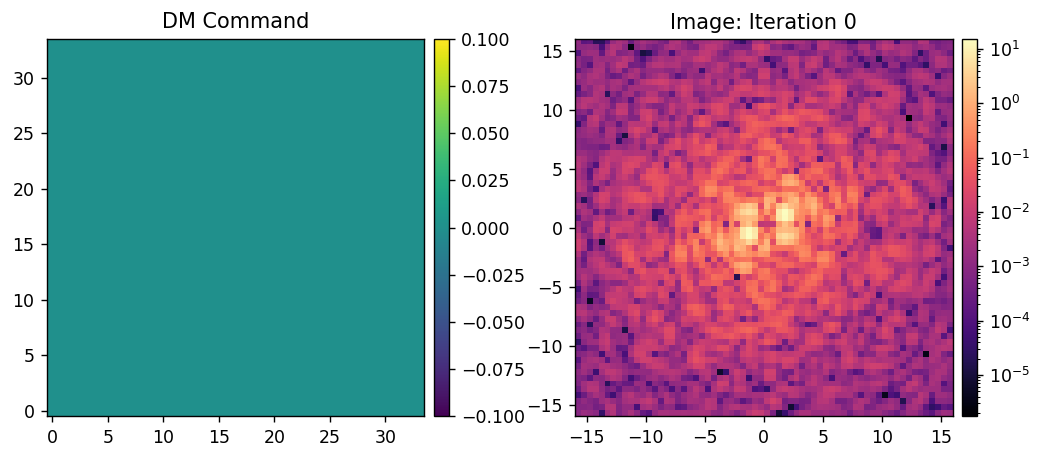

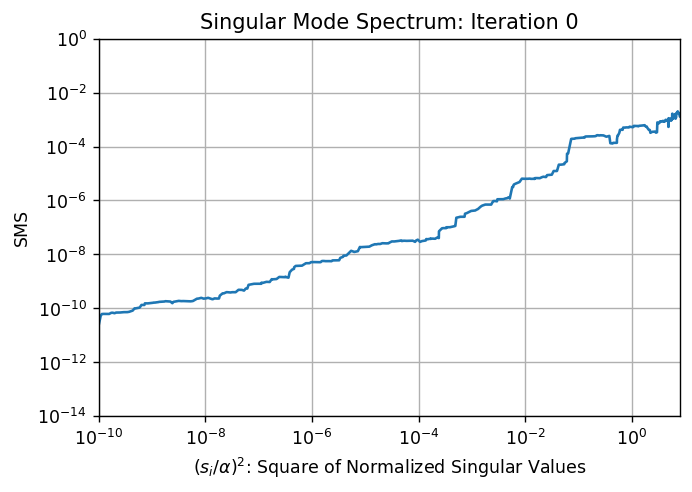

	Running iteration 2/20.


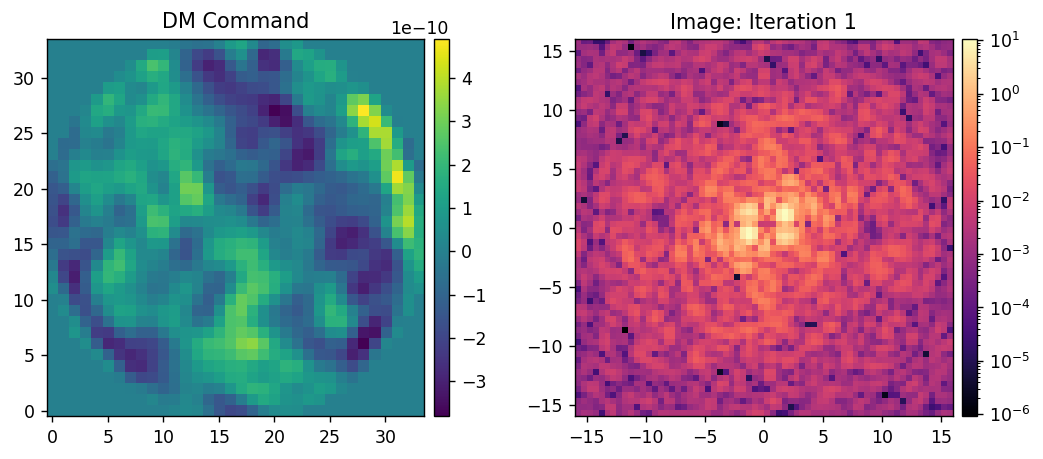

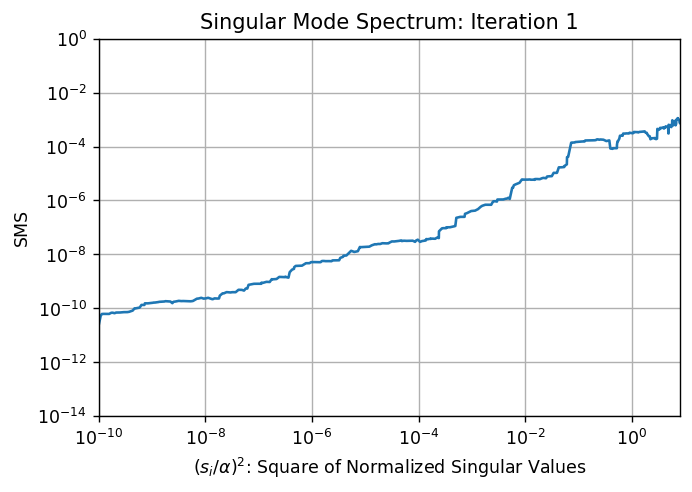

	Running iteration 3/20.


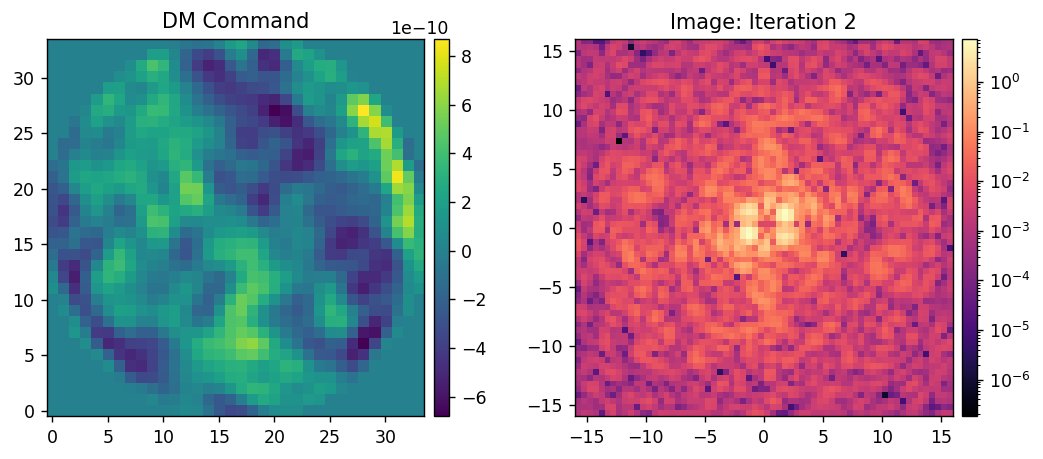

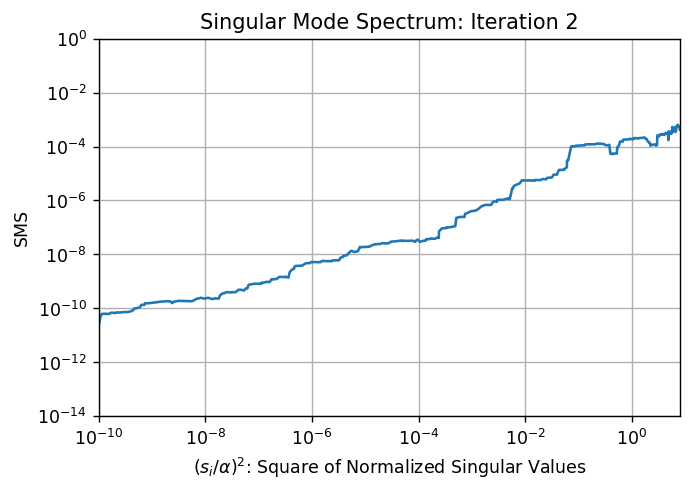

	Running iteration 4/20.


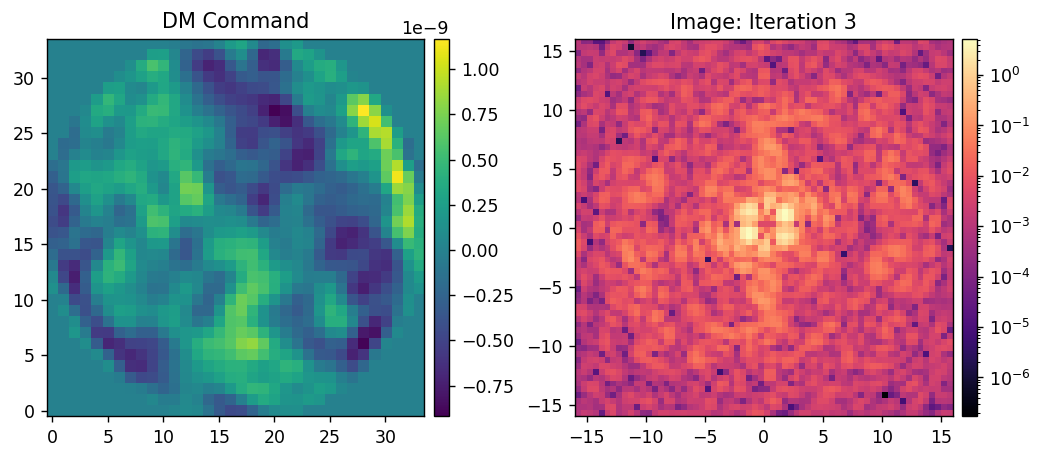

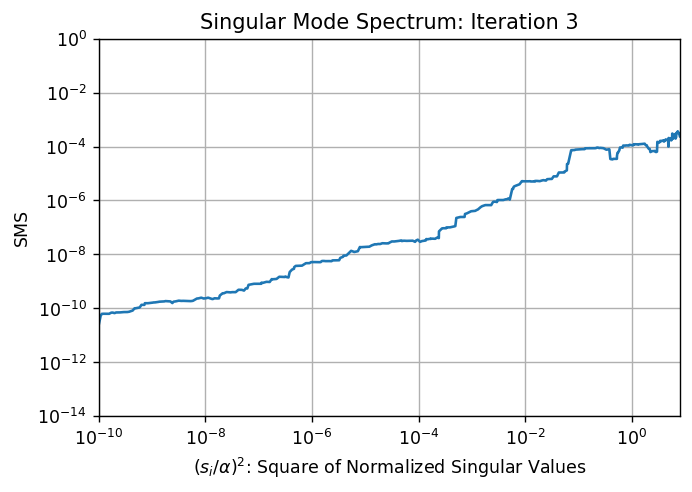

	Running iteration 5/20.


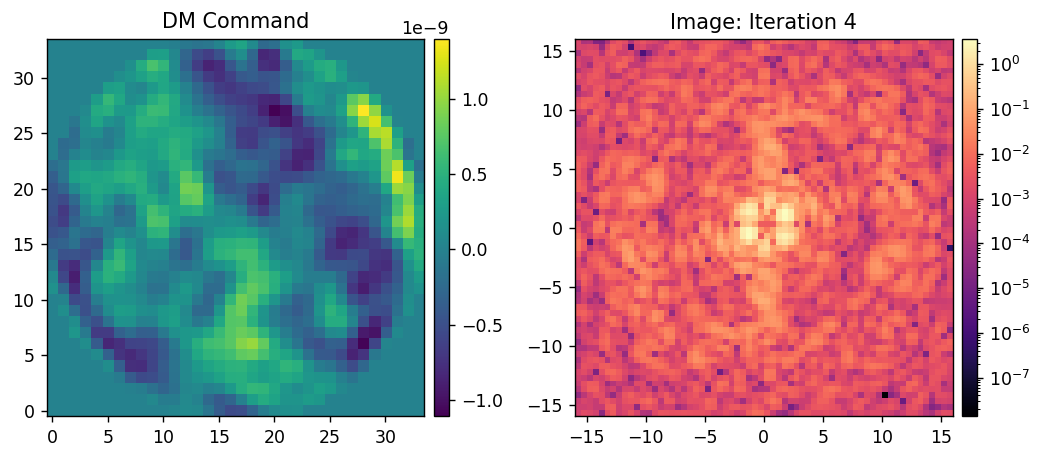

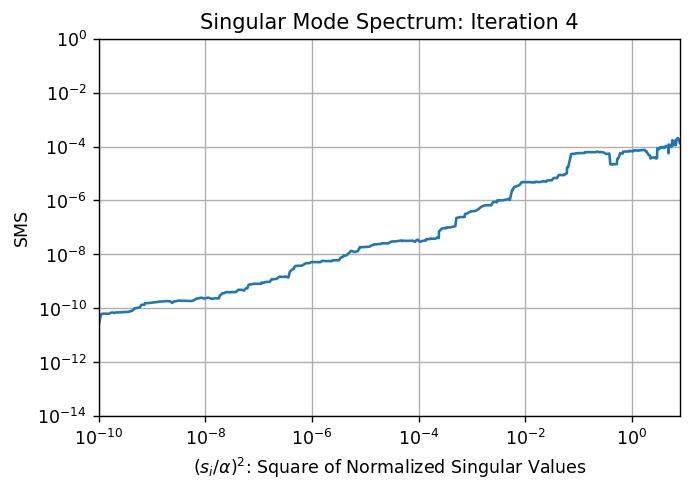

	Running iteration 6/20.


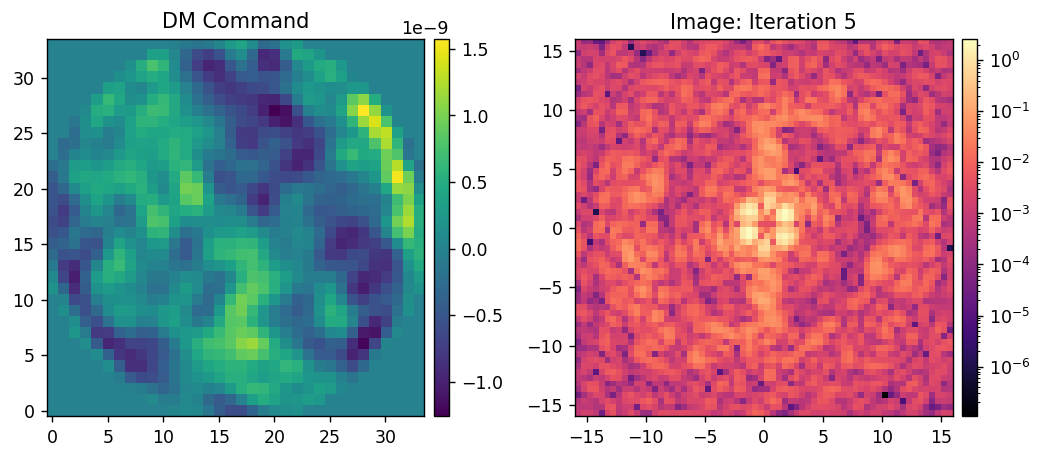

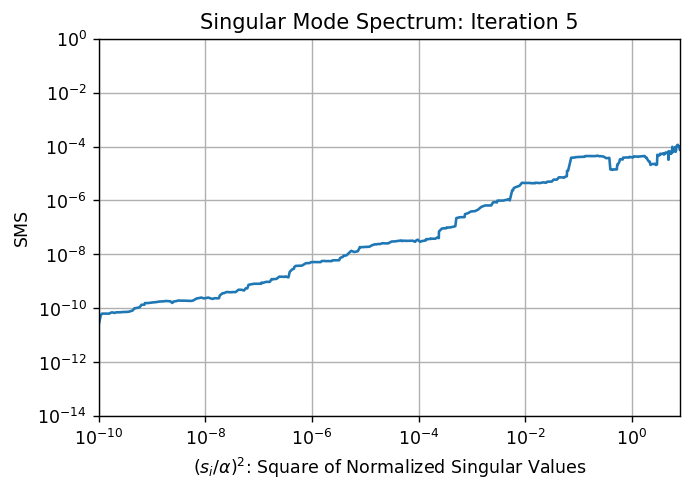

	Running iteration 7/20.


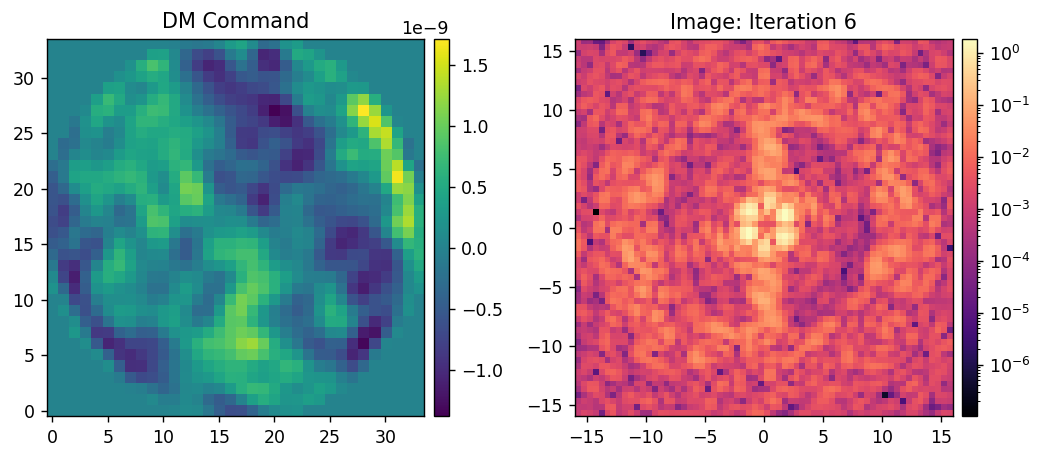

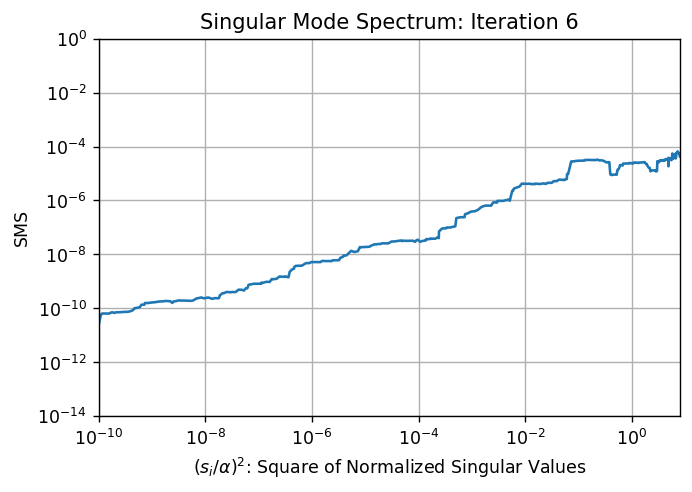

	Running iteration 8/20.


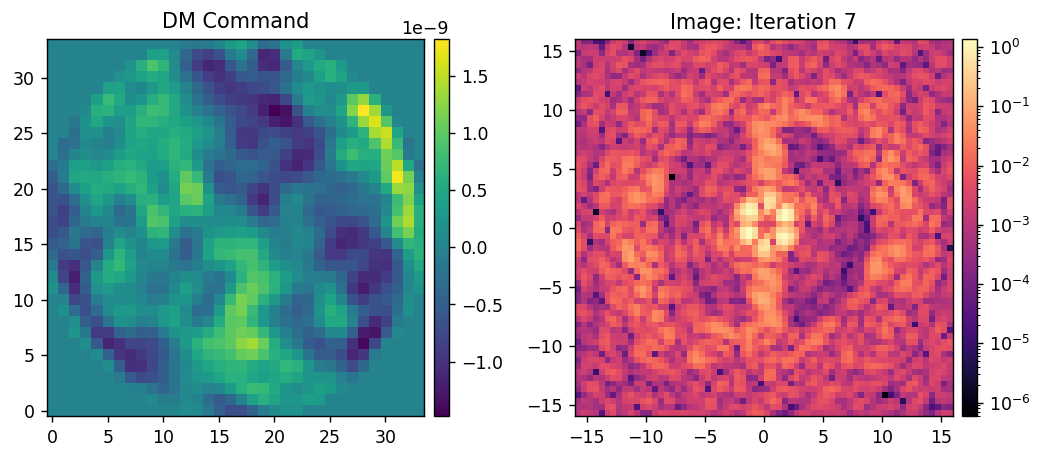

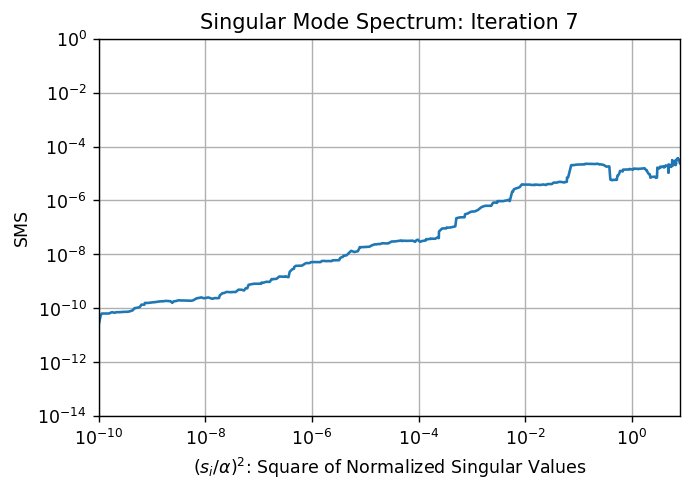

	Running iteration 9/20.


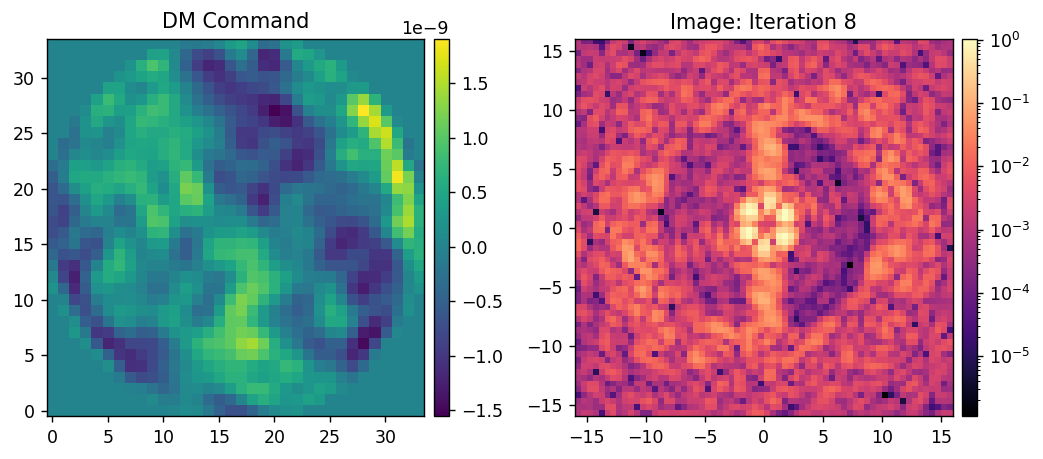

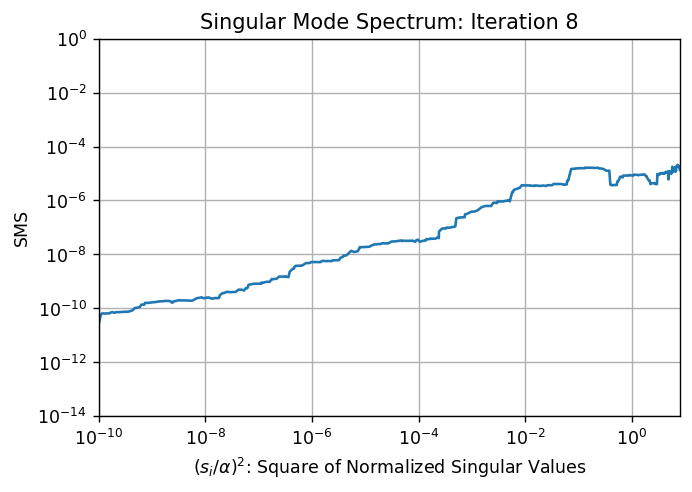

	Running iteration 10/20.


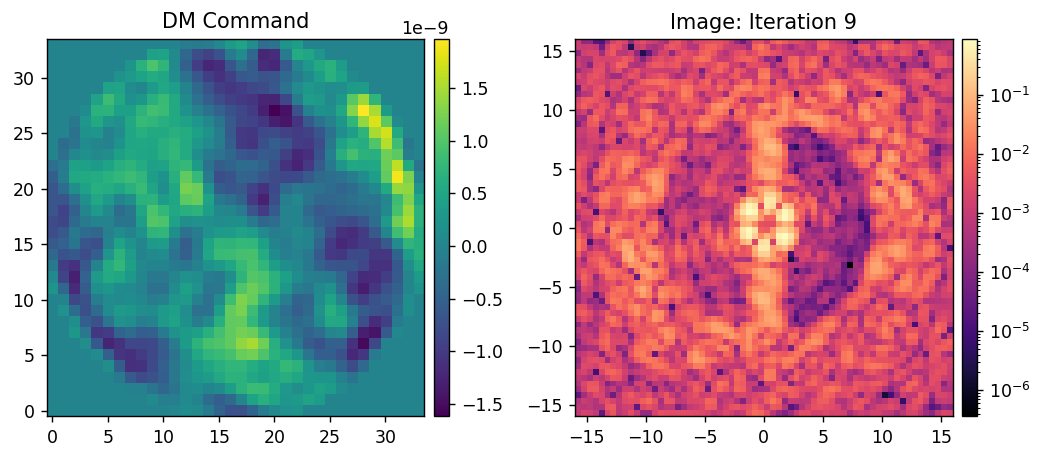

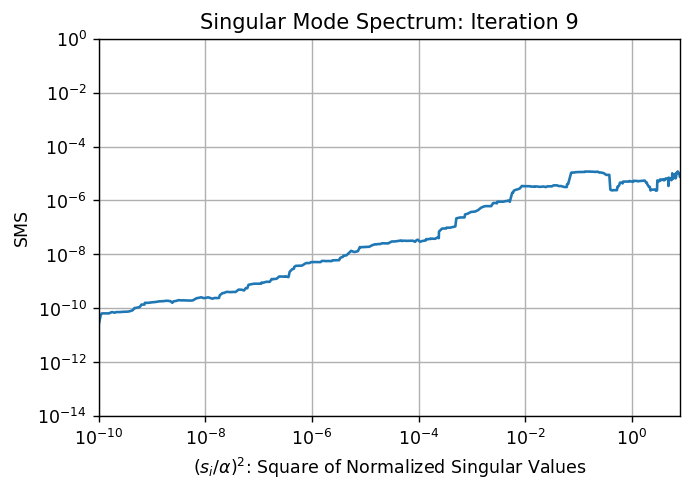

	Running iteration 11/20.


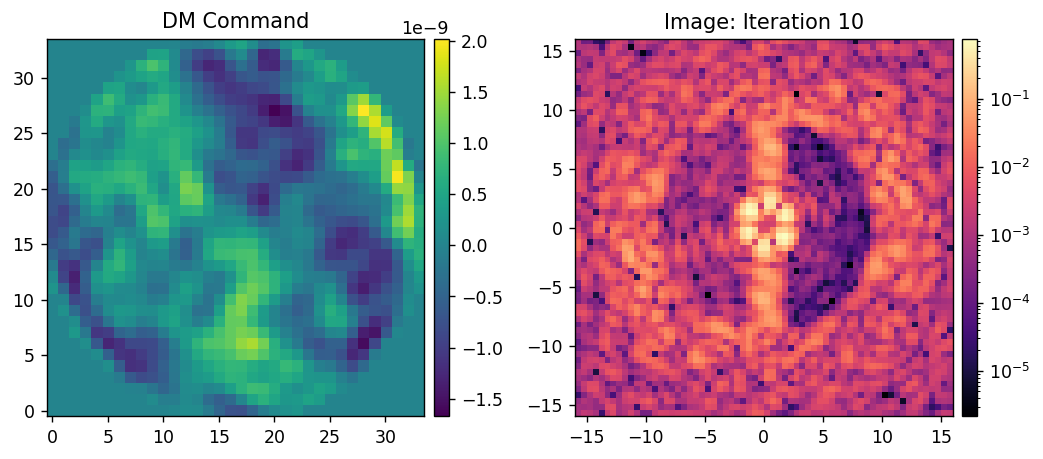

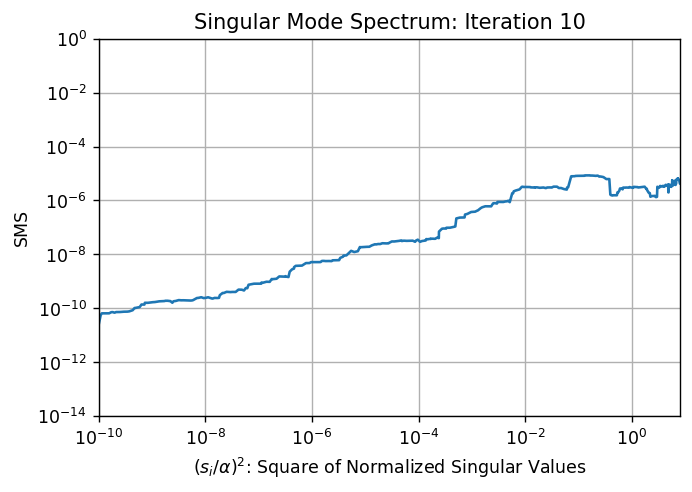

	Running iteration 12/20.


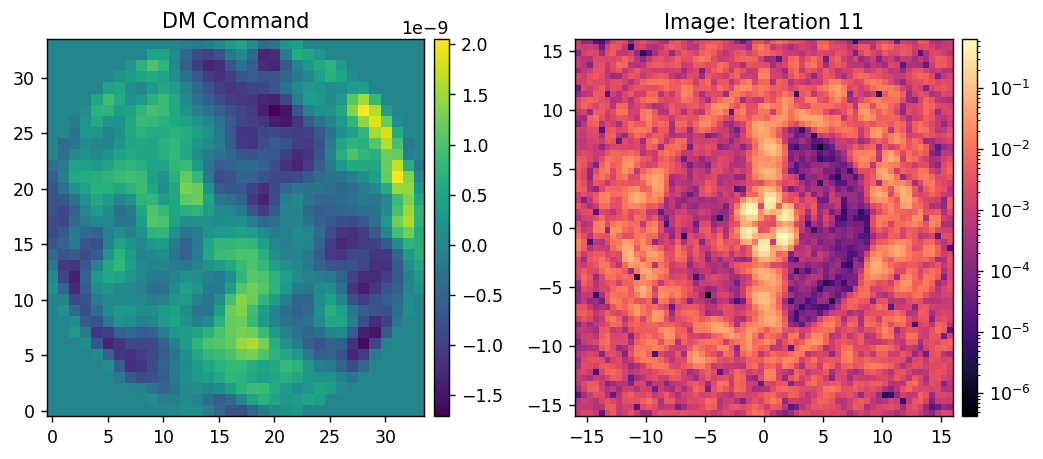

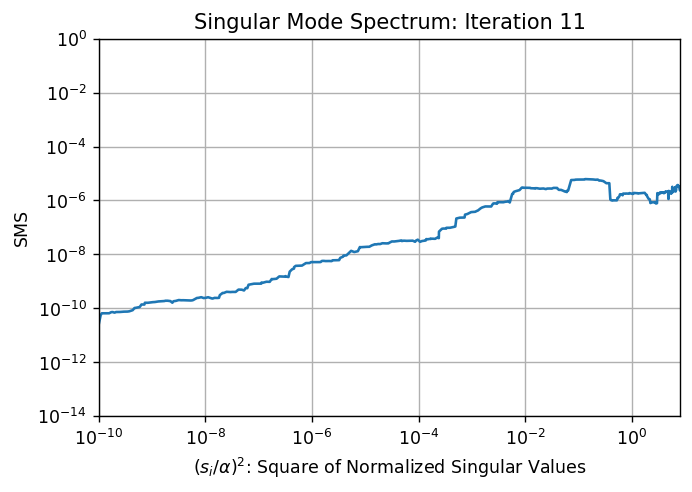

	Running iteration 13/20.


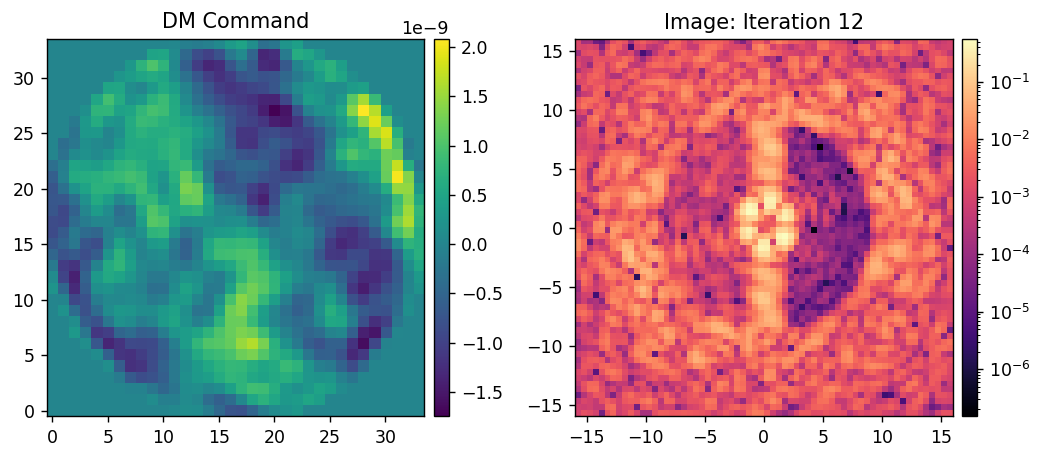

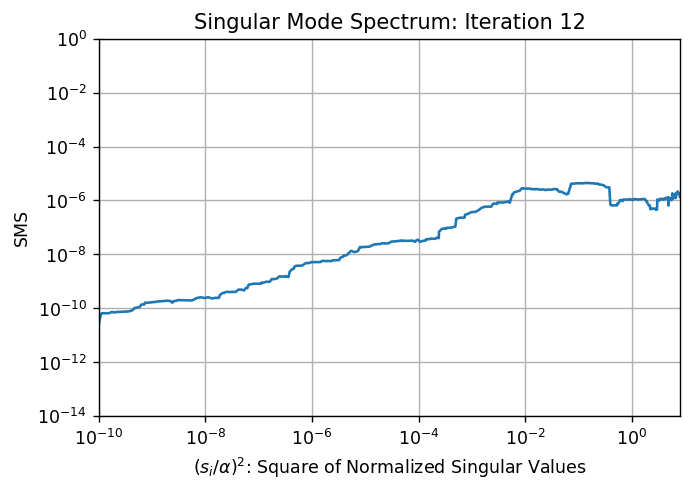

	Running iteration 14/20.


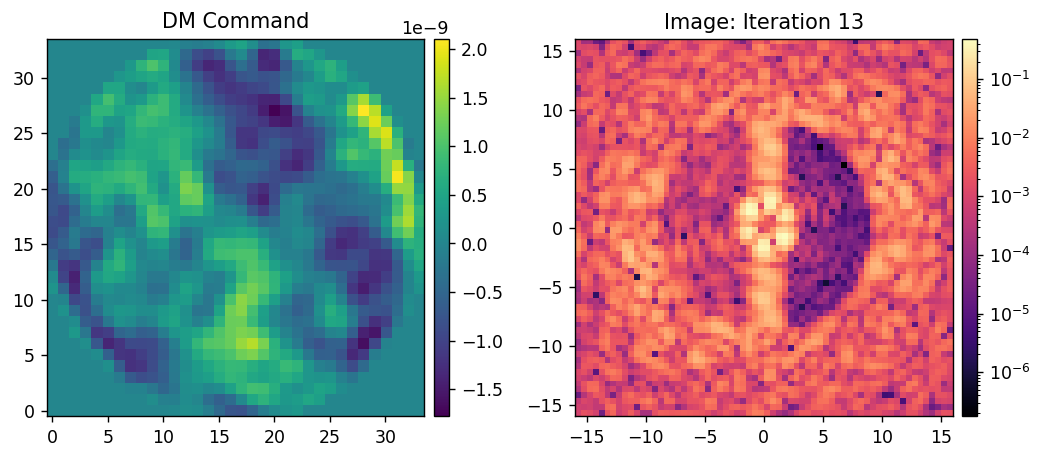

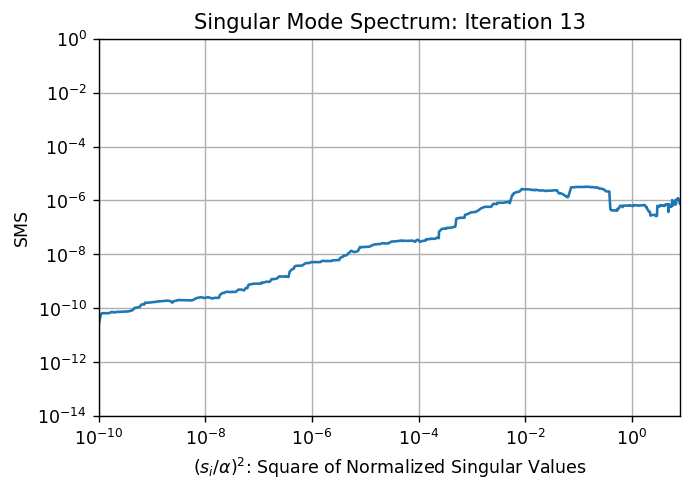

	Running iteration 15/20.


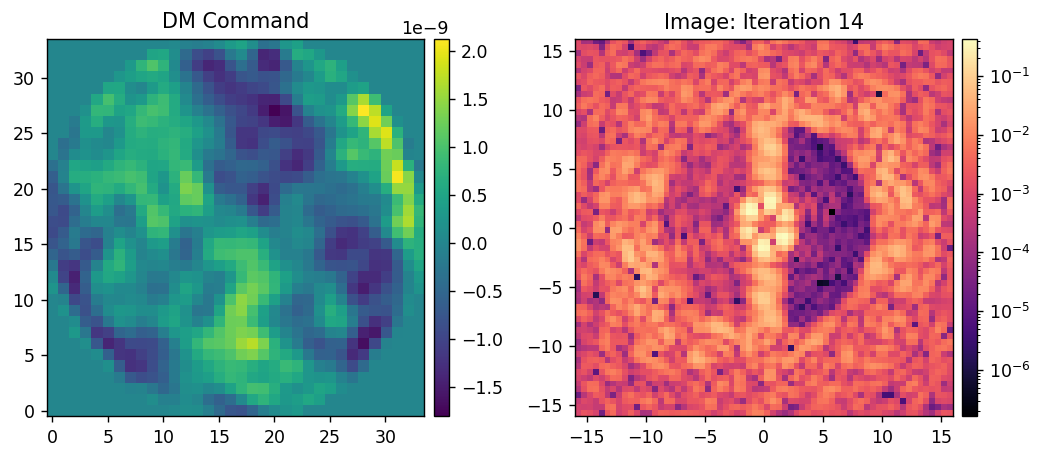

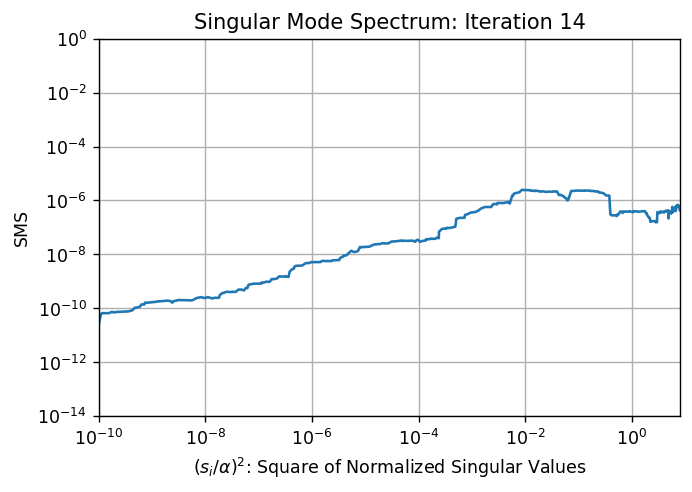

	Running iteration 16/20.


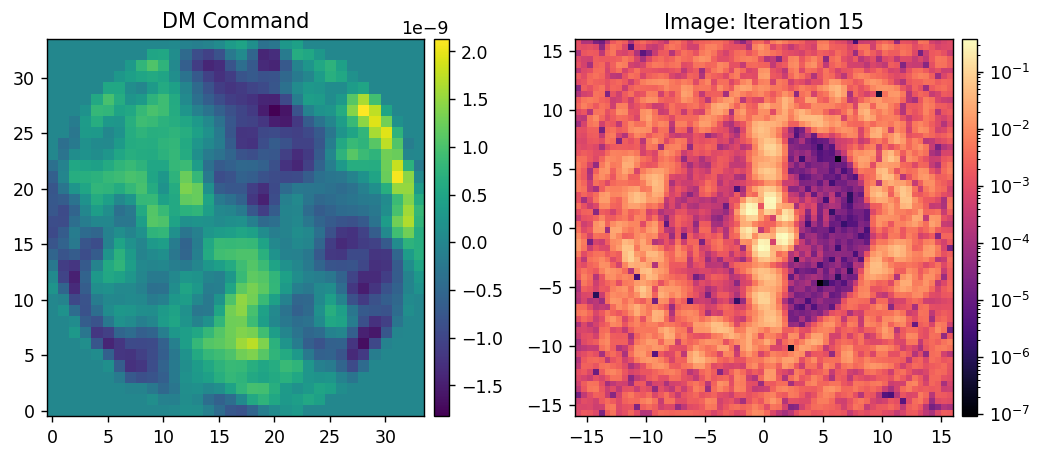

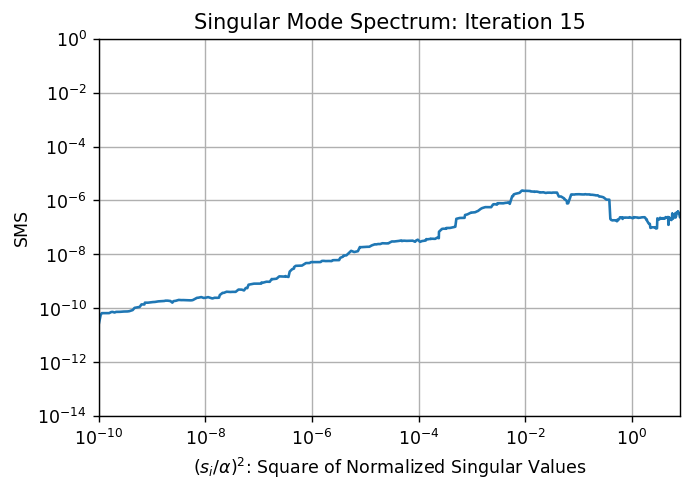

	Running iteration 17/20.


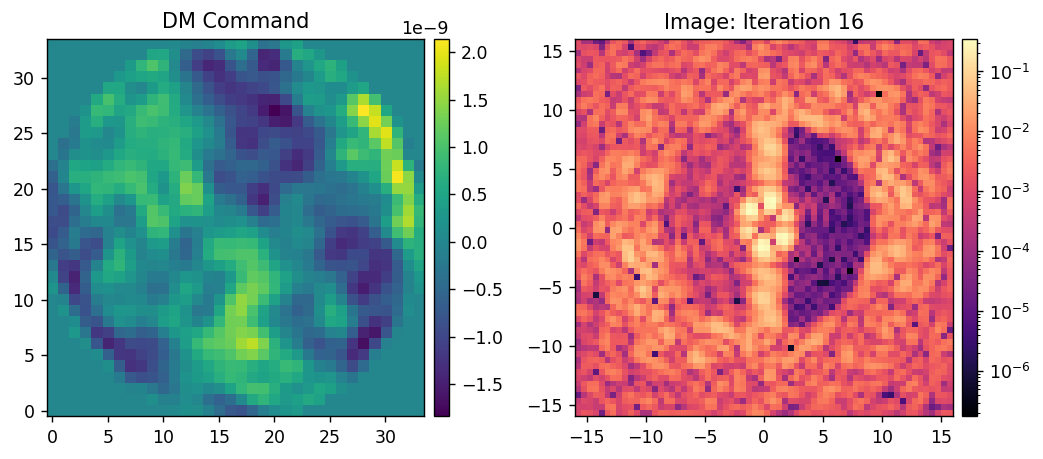

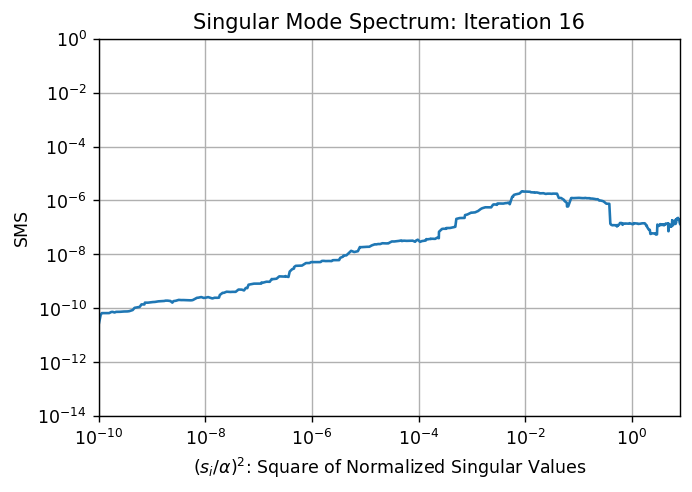

	Running iteration 18/20.


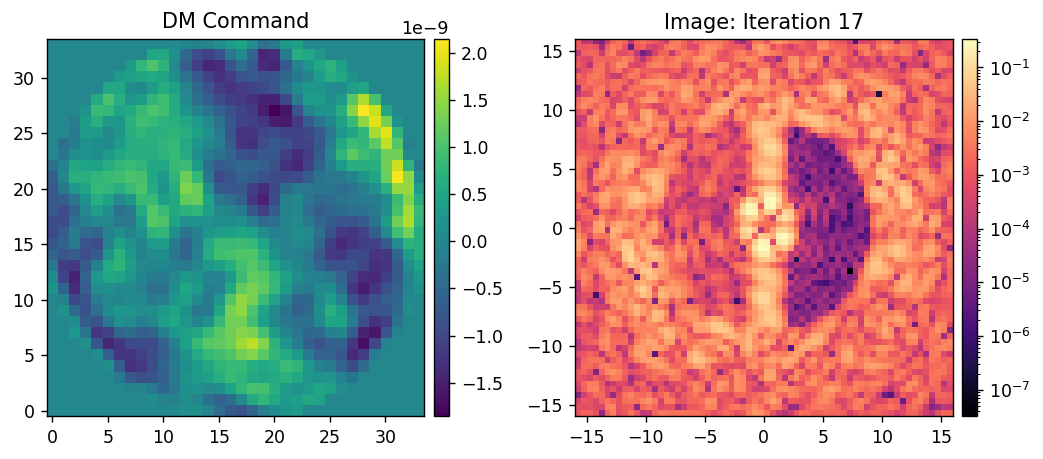

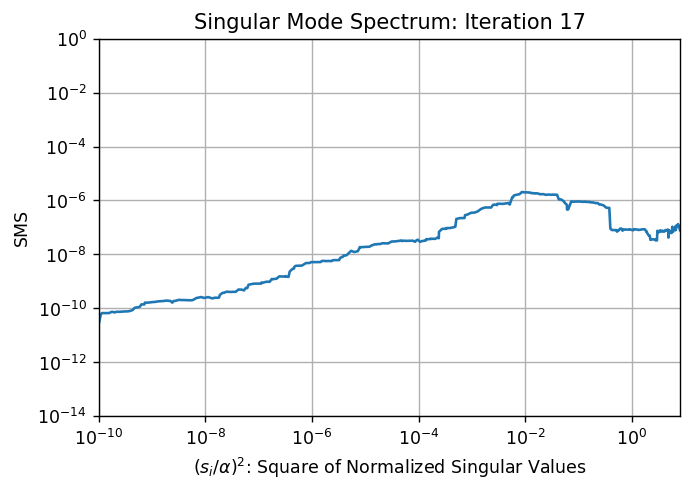

	Running iteration 19/20.


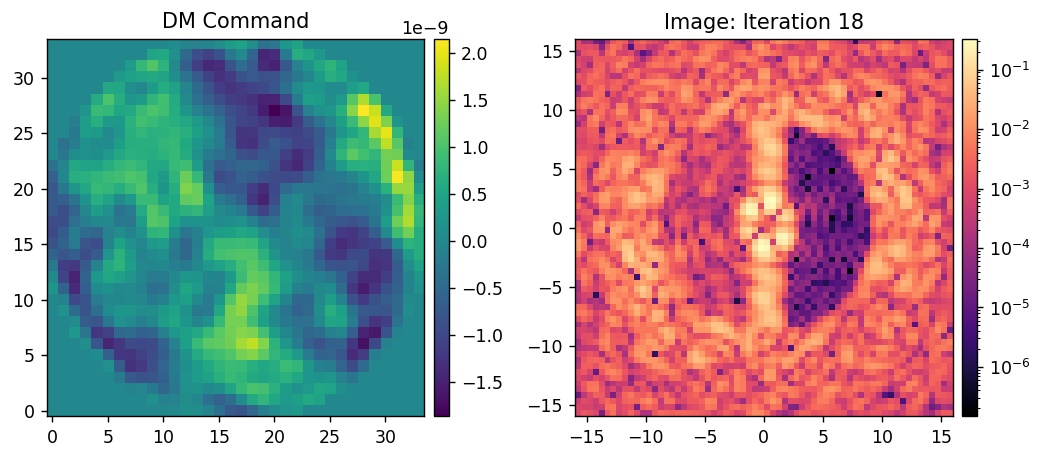

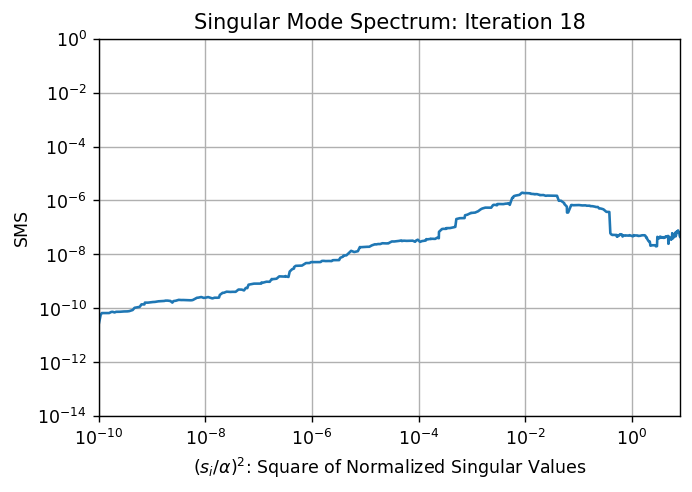

	Running iteration 20/20.


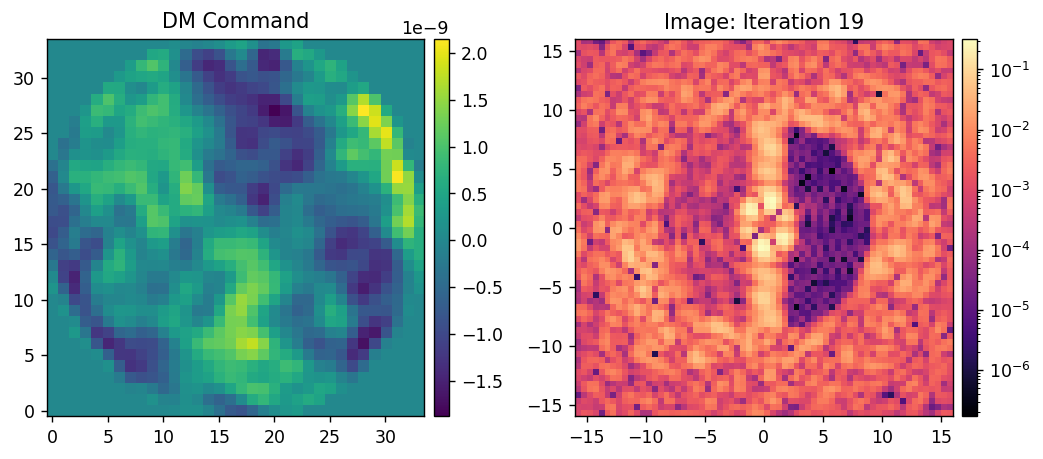

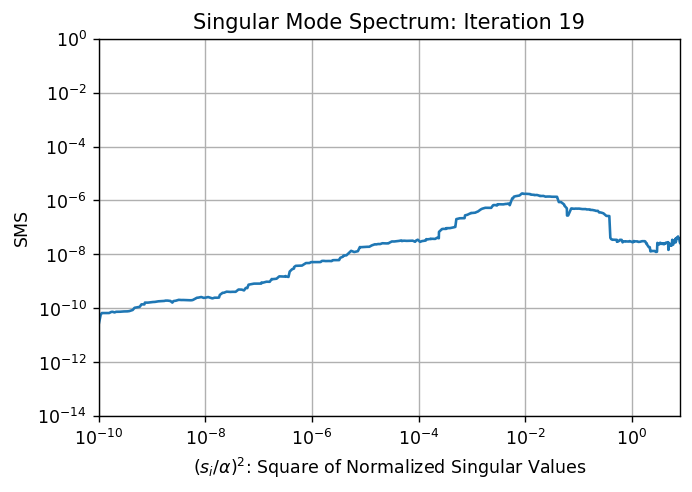

	Running iteration 21/20.


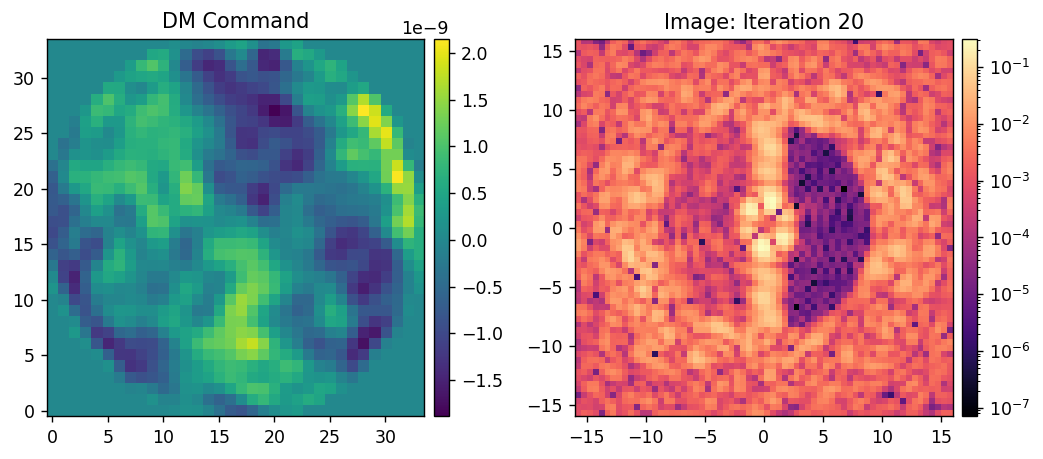

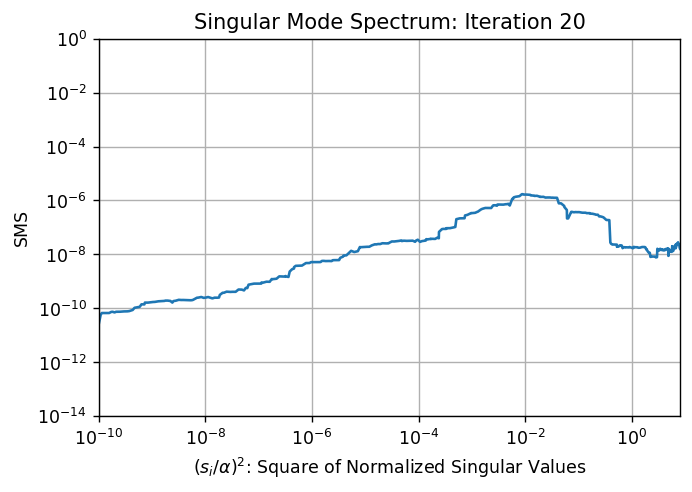

EFC completed in 21.081 sec.


In [17]:
reload(wfsc.efc_2dm)
reload(wfsc.utils)

ims, commands = wfsc.efc_2dm.run_efc_perfect(c, 
                                            jac, 
                                            reg_fun,
                                            reg_conds,
                                            dark_mask, 
                                            Imax_unocc=1,
                                            efc_loop_gain=0.5, 
                                            iterations=20, 
                                            plot_all=True, 
                                            plot_current=True,
                                            plot_sms=True)